## <font color=blue>Contents<font/>

#########################################################################################################

1. **Jupyter setup <br>**
2. **Exploratory Data Analysis (part 2) <br>**
    * **Inspect Distributions**
    * **Remove Outlier Rows and Rerun Distribution Plots** <br><br>
3. **Hypothesis Testing**

#########################################################################################################

## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [2]:
import requests
import sqlite3
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import pylab
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings
from statsmodels.stats.power import TTestIndPower, TTestPower

In [ ]:
pd.set_option('display.max_columns', 50)

In [3]:
df_reduced = pd.read_csv('Movies2018_cleaned.csv', engine='python')

In [4]:
df_reduced.head()

popularity  vote_count_x  vote_average_x release_date original_language_x  \
0      82.250       16683.0             8.3   2018-04-25                  en   
1      38.895       14192.0             7.4   2018-02-13                  en   
2      31.957        6878.0             6.5   2018-06-06                  en   
3      30.431        7607.0             7.5   2018-06-14                  en   
4      31.991        7849.0             6.8   2018-12-07                  en   

                                   genre_ids       belongs_to_collection  \
0          Adventure|Action|Science Fiction|     The Avengers Collection   
1  Adventure|Fantasy|Action|Science Fiction|    Black Panther Collection   
2          Adventure|Action|Science Fiction|    Jurassic Park Collection   
3         Adventure|Animation|Action|Family|  The Incredibles Collection   
4                  Adventure|Fantasy|Action|          Aquaman Collection   

        budget  production_companies production_countries       revenue  \
0  300000000.0        Marvel Studios                   US  2.046240e+09   
1  200000000.0        Marvel Studios                   US  1.346739e+09   
2  170000000.0  Amblin Entertainment                   US  1.303460e+09   
3  200000000.0  Walt Disney Pictures                   US  1.241891e+09   
4  160000000.0             DC Comics                   AU  1.143689e+09   

   day_of_week  month  quarter en_int_lang  collection  
0            2      4        2          en  Collection  
1            1      2        1          en  Collection  
2            2      6        2          en  Collection  
3            3      6        2          en  Collection  
4            4     12        4          en  Collection

In [5]:
df_reduced.columns

Index(['popularity', 'vote_count_x', 'vote_average_x', 'release_date',
       'original_language_x', 'genre_ids', 'belongs_to_collection', 'budget',
       'production_companies', 'production_countries', 'revenue',
       'day_of_week', 'month', 'quarter', 'en_int_lang', 'collection'],
      dtype='object')

In [6]:
categoricals = ['original_language_x', 'genre_ids', 'belongs_to_collection',
                'production_companies', 'production_countries', 'day_of_week', 
                'month', 'quarter', 'en_int_lang', 'collection']
len(categoricals)

10

## Set up definitions for statistical tests

In [7]:
# Welch t-test

def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.8f}", "\n",
          f"Degrees of Freedom= {dof:.4f}")

In [8]:
# Cohen's D for measuring effect size

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return ddef 

In [9]:
# Mann Whitney U test for pairwise comparison of non-parametrics

def mann_whitney_u(x, y):
    stat, p = mannwhitneyu(x, y)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [10]:
# Anova test

def anova(formula, dataframe):
    lm = ols(formula, dataframe).fit()
    table = sm.stats.anova_lm(lm)
    def anova_table(table):
        table['mean_sq'] = table[:]['sum_sq']/table[:]['df']
        table['eta_sq'] = table[:-1]['sum_sq']/sum(table['sum_sq'])
        table['omega_sq'] = (table[:-1]['sum_sq']-(table[:-1]['df']*table['mean_sq'][-1]))/(sum(table['sum_sq'])+table['mean_sq'][-1])
        cols = ['sum_sq', 'df', 'mean_sq', 'eta_sq', 'omega_sq', 'F', 'PR(>F)']
        table=table[cols]
        return table
    return anova_table(table)
    

In [11]:
# Dunn Test

def dunn_test(data_list):
    return sp.posthoc_dunn(data_list, p_adjust='holm')

In [12]:
# Tukey Test

def tukey_test(dependent, independent):
    mc = MultiComparison(dependent, independent)
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [13]:
def kw_test(*args):
    stat, p = kruskal(*args)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

### check outliers for continuous variables

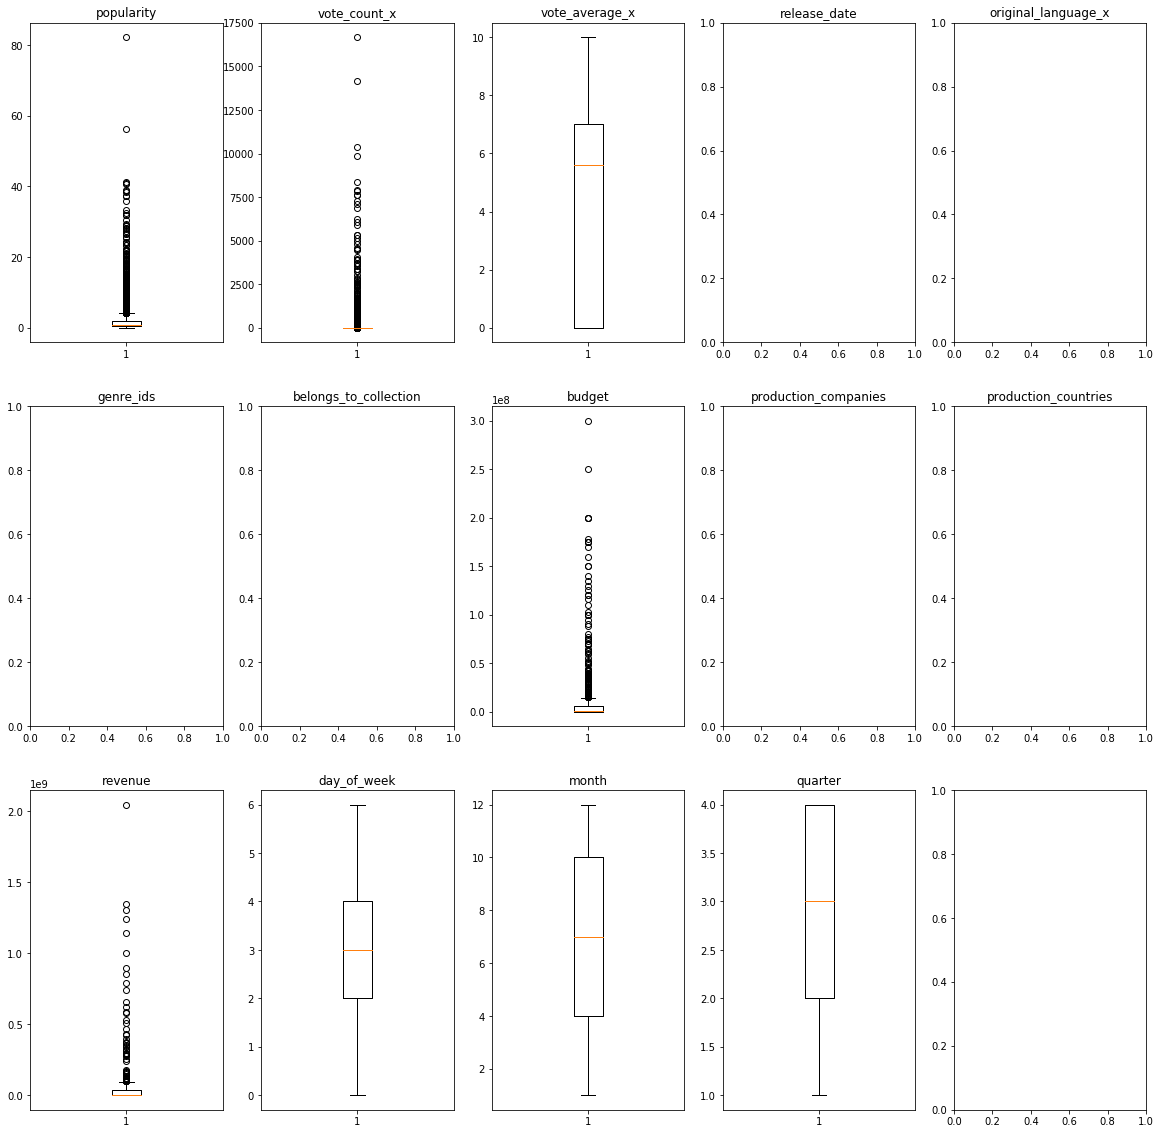

In [14]:
fig2, axes2 = plt.subplots(3, 5, figsize = (20,20))
axes2.shape

for n in range(1,15):
    
    i = df_reduced.dtypes.index[n-1]
    
    row = (n-1)//5
    col = (n-1)%5
    
    if str(i) in ['budget', 'revenue']:
        ax = axes2[row][col]
        ax.boxplot(df_reduced[str(i)].loc[df_reduced[str(i)] > 0])
        ax.set_title('{}'.format(i))
        
    elif str(type(df_reduced[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        ax = axes2[row][col]
        ax.boxplot(df_reduced[str(i)])
        ax.set_title('{}'.format(i))
    else:   
        ax = axes2[row][col]
        ax.set_title('{}'.format(i))
        continue

###   Inspect Distributions

In [15]:
df_vote_average = df_reduced.loc[df_reduced['vote_count_x'] >= 30] 

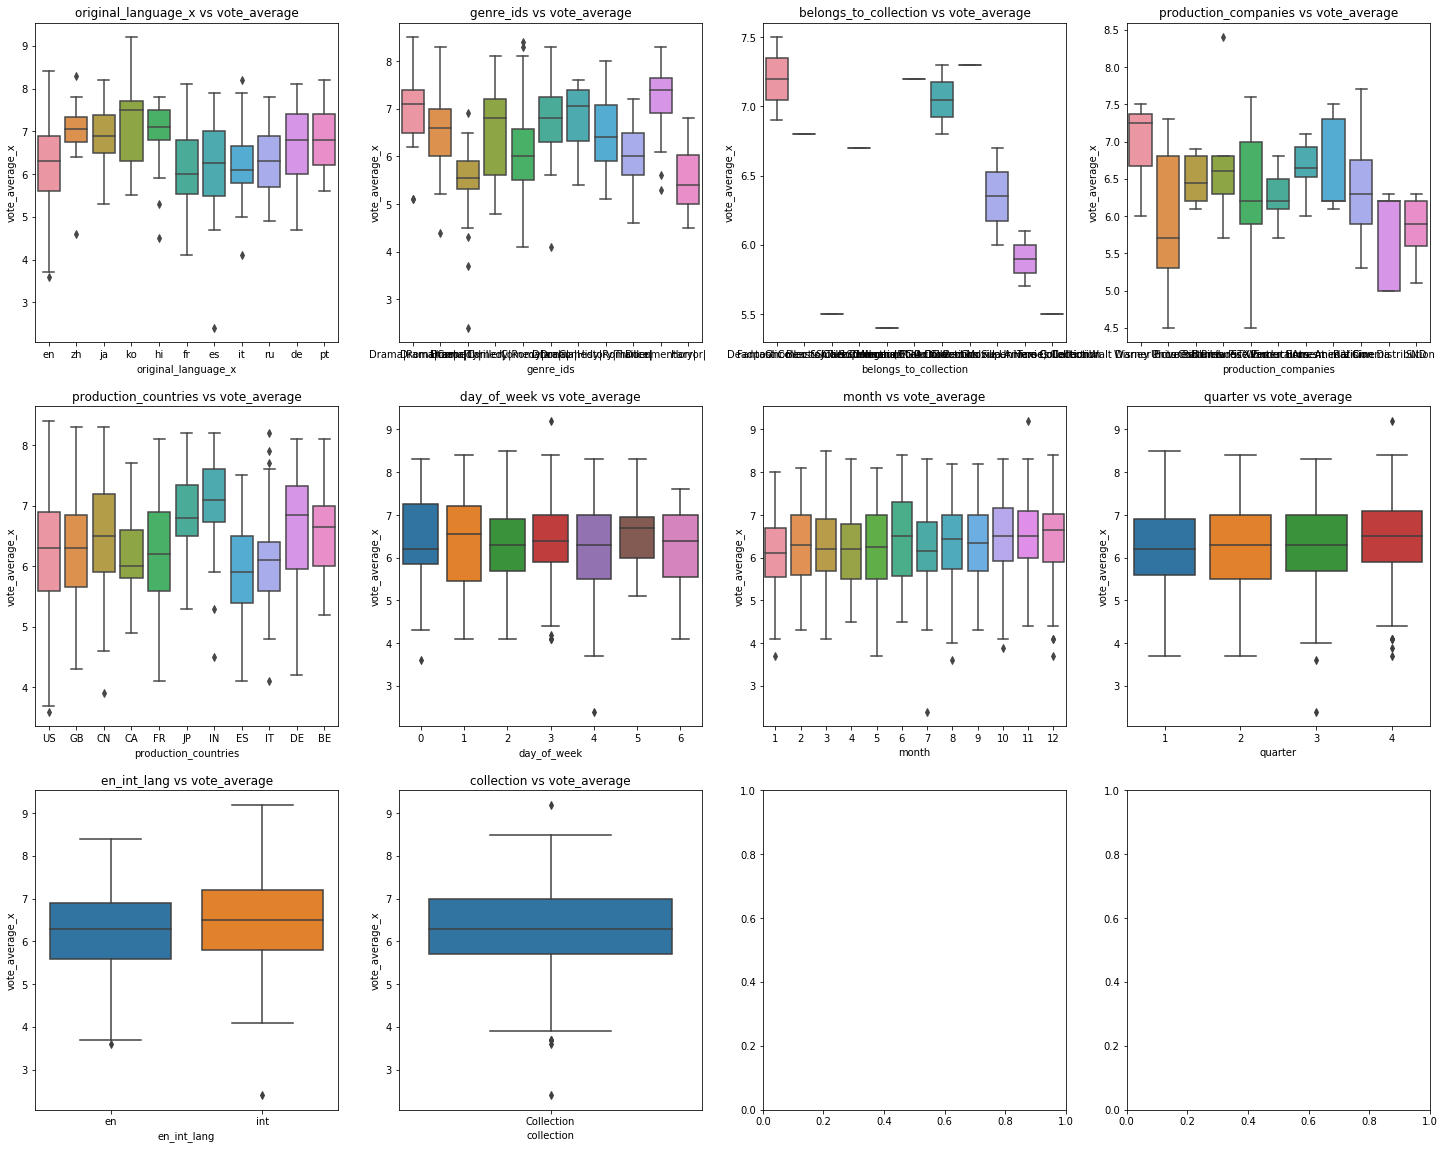

In [16]:
fig3, axes3 = plt.subplots(3, 4, figsize = (25,20))
axes3.shape

for n in range(1,11):
    
    i = categoricals[n-1]
    
    row = (n-1)//4
    col = (n-1)%4
    
    if str(type(df_vote_average[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        
        if (len(df_vote_average[str(i)].unique()) > 12):
            
            ax = axes3[row][col]
            ax.scatter(df_vote_average[str(i)], df_vote_average['vote_average_x'])
            ax.set_title('{}'.format(i) + ' vs vote_average')
            
        
        else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'vote_average_x', data=df_vote_average, ax=ax)
            ax.set_title('{}'.format(i) + ' vs vote_average')
    
    elif (len(df_vote_average[str(i)].unique()) > 12):
        
        top10 = list(df_vote_average[str(i)].loc[df_vote_average[str(i)] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average[df_vote_average[str(i)].isin(top10)]
        
        ax = axes3[row][col]
        sns.boxplot(str(i), 'vote_average_x', data=top10_df, ax=ax)
        ax.set_title('{}'.format(i) + ' vs vote_average') 
            
        
    else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'vote_average_x', data=df_vote_average, ax=ax)
            ax.set_title('{}'.format(i) + ' vs vote_average') 

Categories of initial interest are: en_int_lang, genre_ids, quarter and month

In [17]:
categories_of_further_interest = ['en_int_lang', 'genre_ids', 'quarter', 'month']

en_int_lang , en NormaltestResult(statistic=5.1460343744506245, pvalue=0.07630497137143663)
en_int_lang , int NormaltestResult(statistic=4.65542416075279, pvalue=0.09751860678391161)
genre_ids , Comedy| NormaltestResult(statistic=4.084045823354522, pvalue=0.12976594015140538)
genre_ids , Drama| NormaltestResult(statistic=4.870463577202151, pvalue=0.08757744524176653)
genre_ids , Drama|Comedy| NormaltestResult(statistic=0.6469928201872197, pvalue=0.7236145556262367)
genre_ids , Documentary| NormaltestResult(statistic=6.004884885099243, pvalue=0.04966561469584742)
genre_ids , Horror|Thriller| NormaltestResult(statistic=16.66106272647722, pvalue=0.00024104392896078907)
genre_ids , Comedy|Romance| NormaltestResult(statistic=0.7204206321251148, pvalue=0.6975296089622154)
genre_ids , Drama|Comedy|Romance| NormaltestResult(statistic=2.6414427328440597, pvalue=0.26694266901669744)


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


genre_ids , Drama|Romance| NormaltestResult(statistic=2.393955285952264, pvalue=0.30210590539171966)
genre_ids , Thriller| NormaltestResult(statistic=0.2645620800012429, pvalue=0.8760947428105613)


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


genre_ids , Horror| NormaltestResult(statistic=0.9254467621670106, pvalue=0.6295667584983782)
genre_ids , Drama|History| NormaltestResult(statistic=1.4784916463421958, pvalue=0.47747387950205233)
quarter , 3 NormaltestResult(statistic=14.68585336885792, pvalue=0.0006471537318962803)
quarter , 4 NormaltestResult(statistic=3.241022360100775, pvalue=0.19779756306820453)
quarter , 2 NormaltestResult(statistic=5.675377698412538, pvalue=0.05856085264699919)
quarter , 1 NormaltestResult(statistic=1.7063681074288604, pvalue=0.4260561841579651)
month , 9 NormaltestResult(statistic=1.2768246718939904, pvalue=0.5281302521889473)
month , 10 NormaltestResult(statistic=0.7443690951196617, pvalue=0.6892270356191287)
month , 3 NormaltestResult(statistic=0.13498999700991937, pvalue=0.9347323956637773)
month , 8 NormaltestResult(statistic=2.9782261305360773, pvalue=0.2255726350465467)


/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


month , 5 NormaltestResult(statistic=2.6770100060289335, pvalue=0.26223741982603005)
month , 11 NormaltestResult(statistic=1.1305603228864487, pvalue=0.5682009364618882)
month , 4 NormaltestResult(statistic=0.5940917958354415, pvalue=0.7430099089716409)
month , 6 NormaltestResult(statistic=12.181366347063962, pvalue=0.002263861775946942)
month , 2 NormaltestResult(statistic=2.053429621414668, pvalue=0.35818172461800357)
month , 1 NormaltestResult(statistic=0.7076159948888628, pvalue=0.7020097420809477)
month , 12 NormaltestResult(statistic=5.027242017502316, pvalue=0.08097449837548487)
month , 7 NormaltestResult(statistic=15.990968298565274, pvalue=0.0003369809527352625)


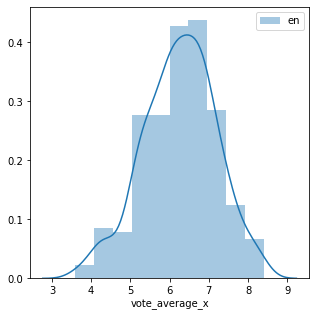

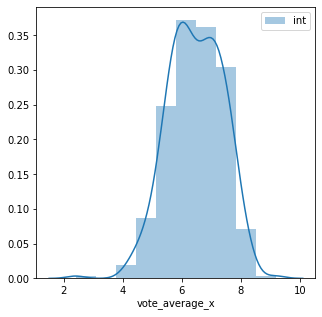

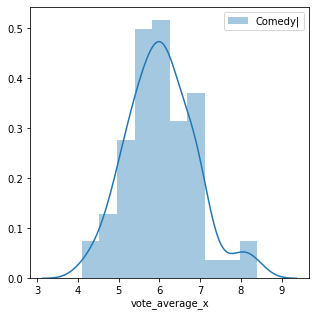

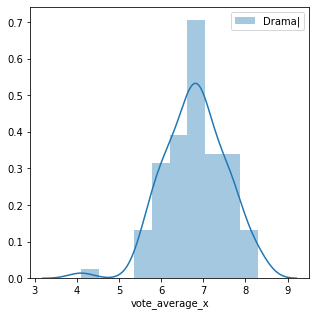

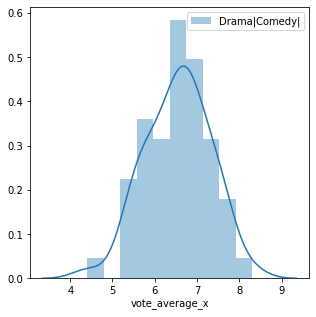

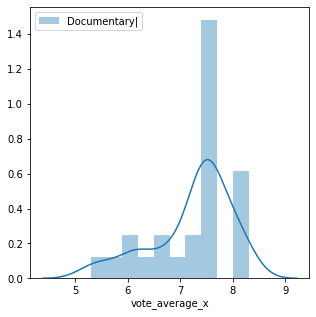

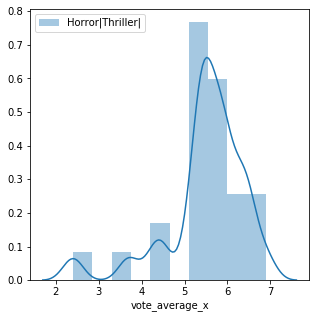

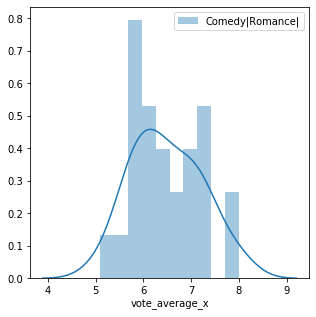

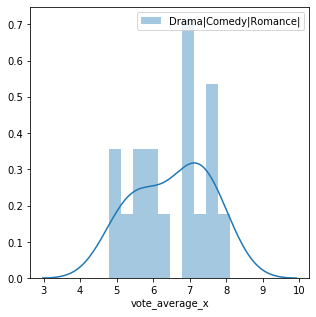

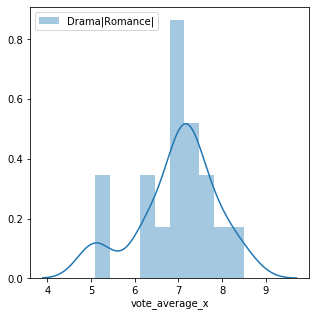

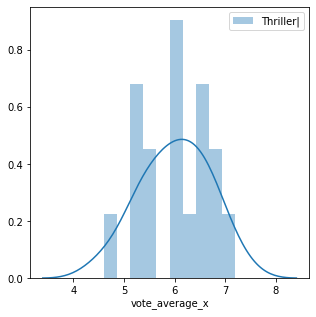

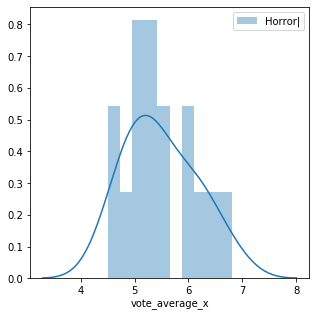

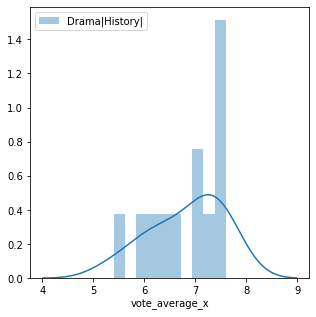

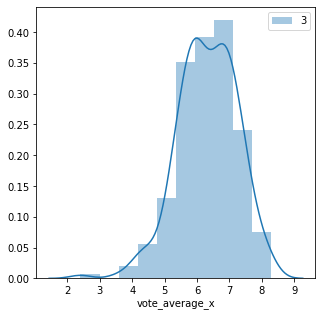

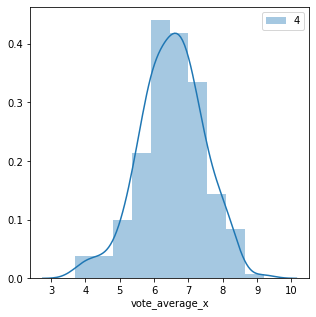

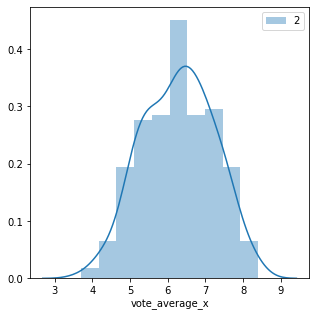

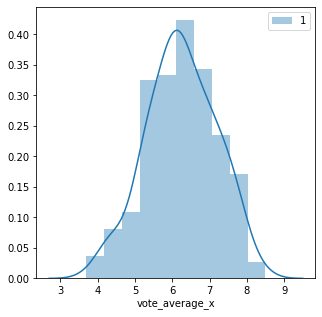

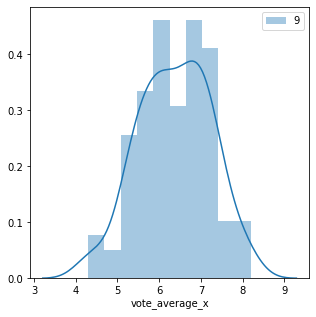

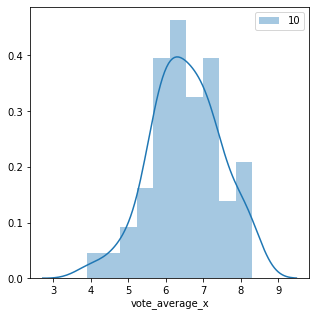

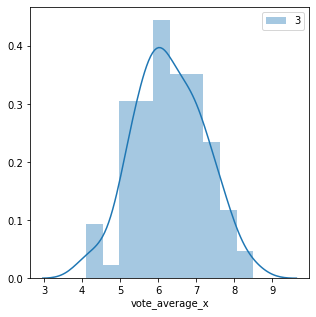

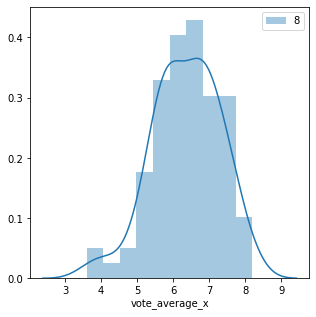

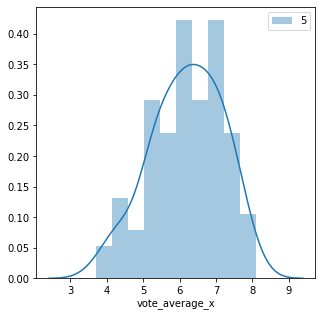

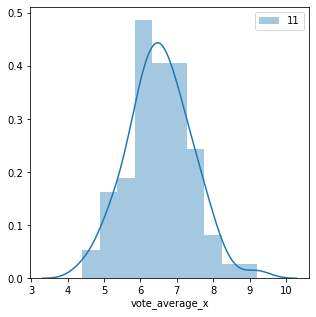

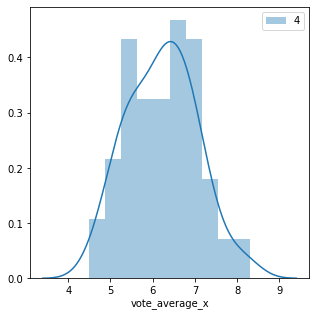

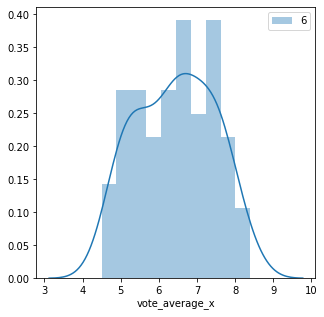

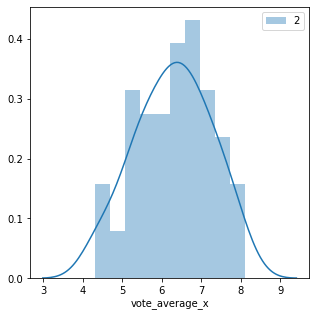

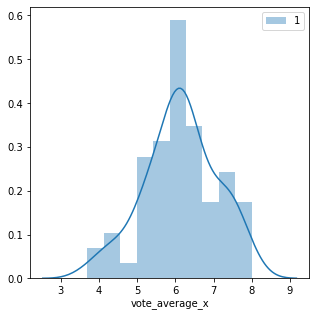

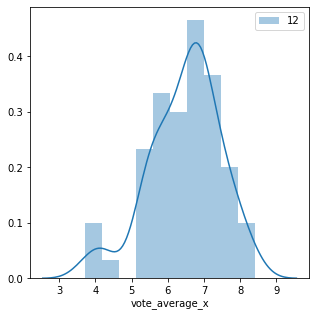

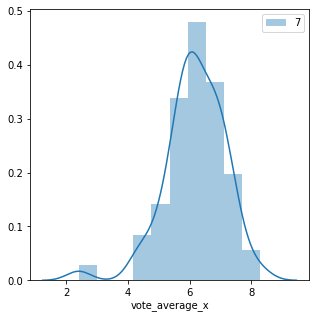

In [18]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        exec(f'{cat} = top10_df.copy()')
    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        exec(f'{cat} = top10_df.copy()')
        
    for i in top10:    
        print(cat, ',', i, stats.normaltest(list(top10_df[top10_df[cat] == i]['vote_average_x'])))
        
        fig = plt.figure(figsize = (5, 5))
        sns.distplot(top10_df[top10_df[cat] == i]['vote_average_x'], bins = 10, label=i)
        plt.legend()

Many of the categories of interests are normally distributed but some are not but close to being normal except for some skewness. So will remove extreme outliers from each category in an attempt to reduce skewness and make more normal.

In [19]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]


    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        
        
    exec(f"{cat}[str(cat) +  '_outlier_flag'] = 0")
    for i in top10:
    
        exec(f"data_mean, data_std = np.mean({cat}.loc[{cat}[cat] == i]['vote_average_x']), np.std({cat}.loc[{cat}[cat] == i]['vote_average_x'])")   
        cut_off = data_std * 3
        upper, lower = data_mean + cut_off, data_mean - cut_off
    
        exec(f"{cat}.loc[{cat}[cat] == i, (str(cat) +  '_outlier_flag')] = (({cat}.loc[{cat}[cat] == i]['vote_average_x'] >= upper) | ({cat}.loc[{cat}[cat] == i]['vote_average_x'] <= lower))")


en_int_lang , en NormaltestResult(statistic=5.1460343744506245, pvalue=0.07630497137143663)
en_int_lang , int NormaltestResult(statistic=7.580190847881082, pvalue=0.022593445792625778)
genre_ids , Comedy| NormaltestResult(statistic=4.084045823354522, pvalue=0.12976594015140538)
genre_ids , Drama| NormaltestResult(statistic=2.3902320093393423, pvalue=0.3026688411466072)
genre_ids , Drama|Comedy| NormaltestResult(statistic=0.6469928201872197, pvalue=0.7236145556262367)
genre_ids , Documentary| NormaltestResult(statistic=6.004884885099243, pvalue=0.04966561469584742)
genre_ids , Horror|Thriller| NormaltestResult(statistic=4.778953654248388, pvalue=0.09167763458488924)
genre_ids , Comedy|Romance| NormaltestResult(statistic=0.7204206321251148, pvalue=0.6975296089622154)
genre_ids , Drama|Comedy|Romance| NormaltestResult(statistic=2.6414427328440597, pvalue=0.26694266901669744)
genre_ids , Drama|Romance| NormaltestResult(statistic=2.393955285952264, pvalue=0.30210590539171966)
genre_ids , Th

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


month , 6 NormaltestResult(statistic=12.181366347063962, pvalue=0.002263861775946942)
month , 2 NormaltestResult(statistic=2.053429621414668, pvalue=0.35818172461800357)
month , 1 NormaltestResult(statistic=0.7076159948888628, pvalue=0.7020097420809477)
month , 12 NormaltestResult(statistic=5.027242017502316, pvalue=0.08097449837548487)
month , 7 NormaltestResult(statistic=0.15063047463065396, pvalue=0.9274510730548199)


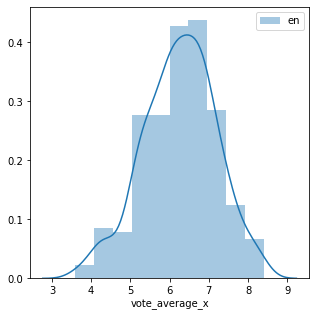

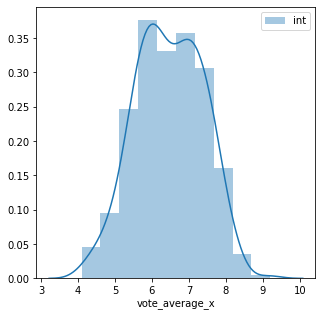

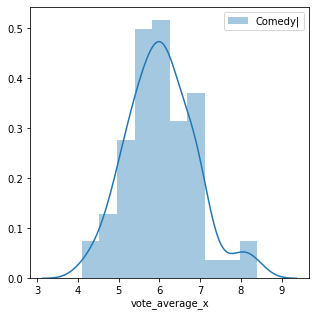

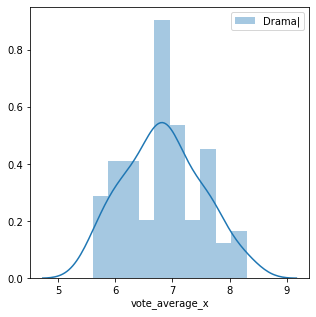

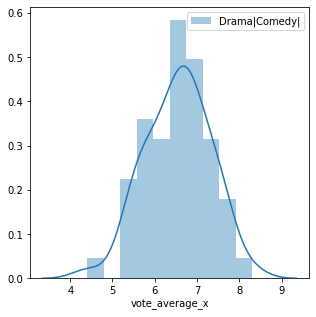

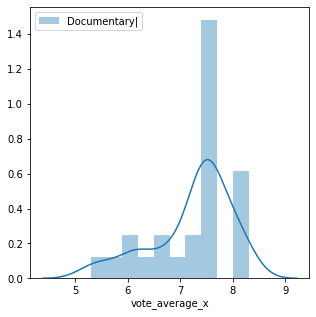

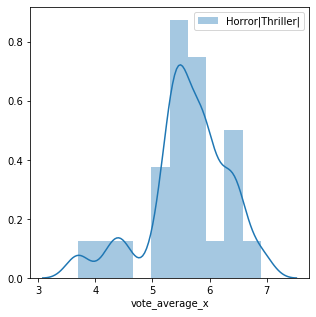

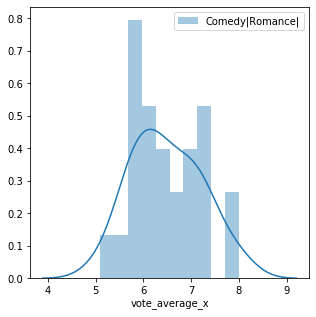

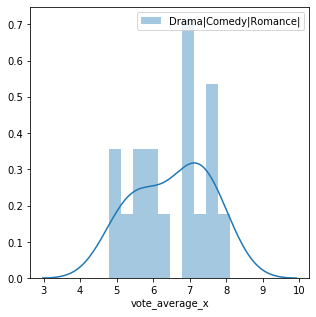

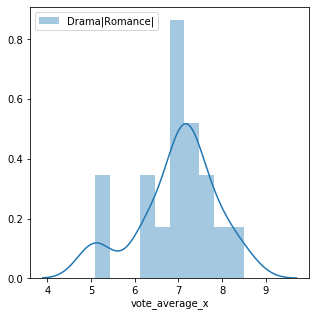

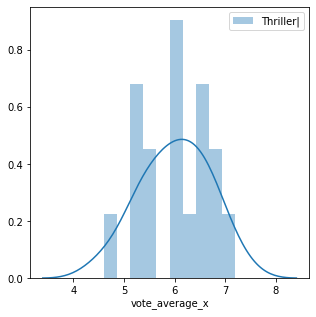

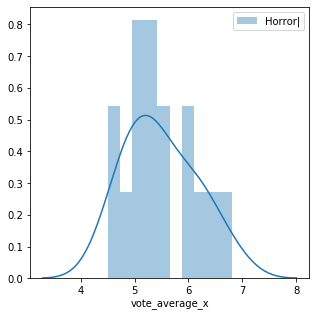

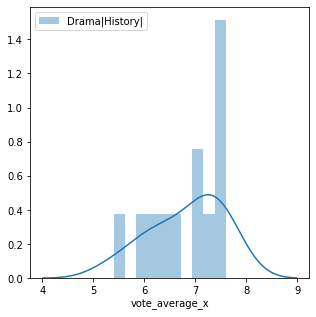

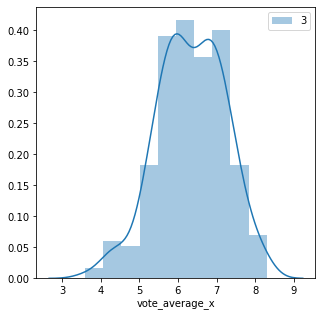

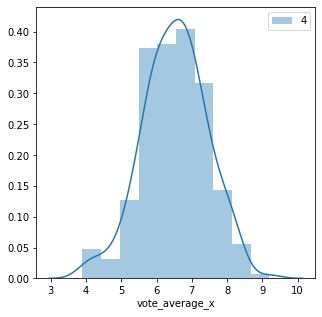

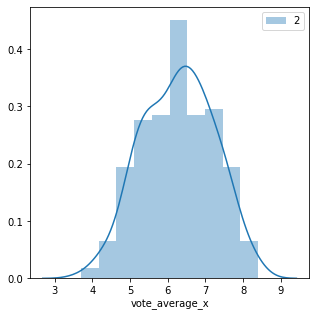

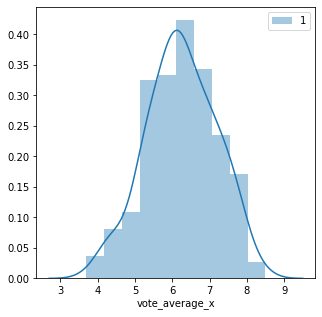

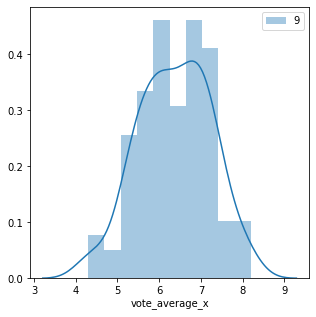

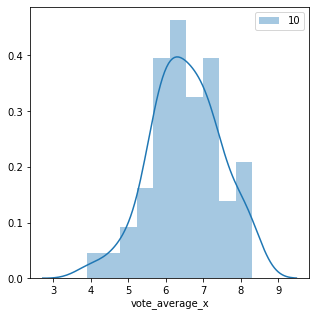

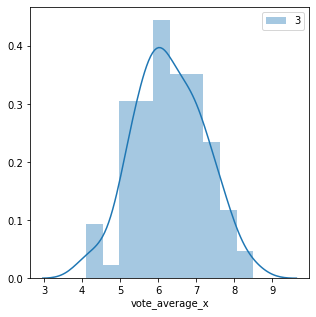

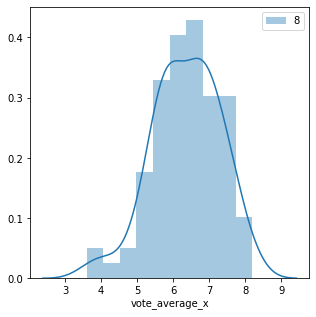

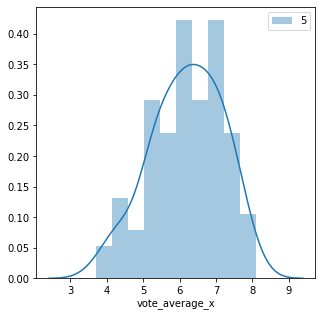

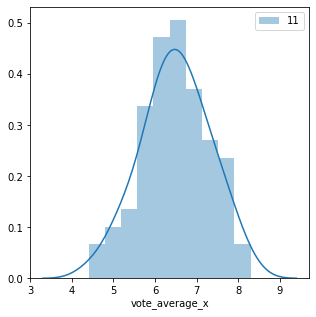

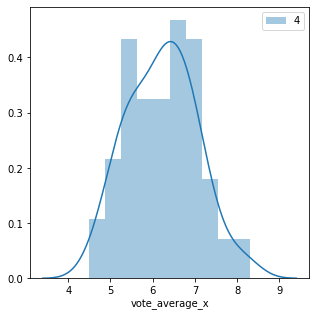

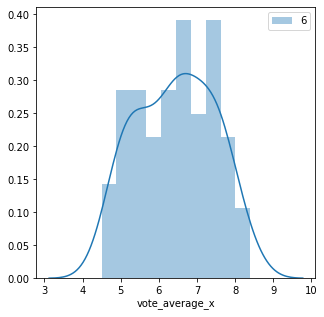

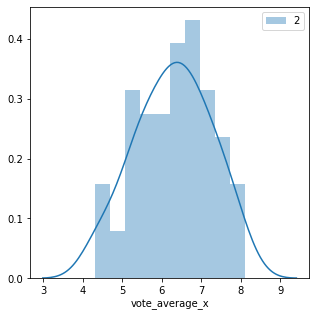

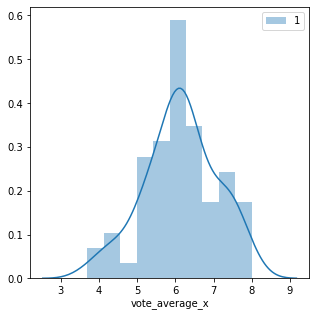

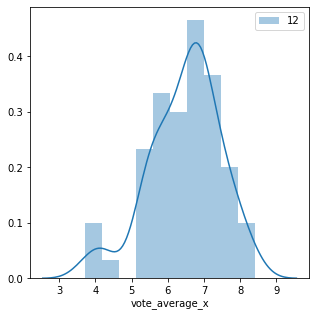

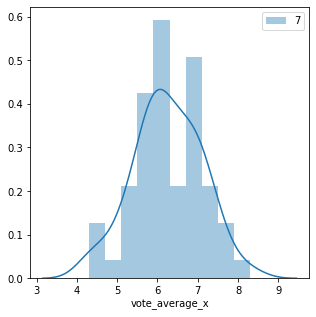

In [20]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]


    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]
    
    for i in top10:    
        exec(f"print(cat, ',', i, stats.normaltest(list({cat}[({cat}[cat + '_outlier_flag'] == False) & ({cat}[cat] == i)]['vote_average_x'])))")
        
        fig = plt.figure(figsize = (5, 5))
        exec(f"sns.distplot({cat}[({cat}[cat + '_outlier_flag'] == False) & ({cat}[cat] == i)]['vote_average_x'], bins = 10, label=i)")
        plt.legend()

### `en_int_lang`

In [21]:
en_int_lang_no_outliers = en_int_lang.loc[en_int_lang['en_int_lang_outlier_flag'] == False, ['en_int_lang', 'vote_average_x']]

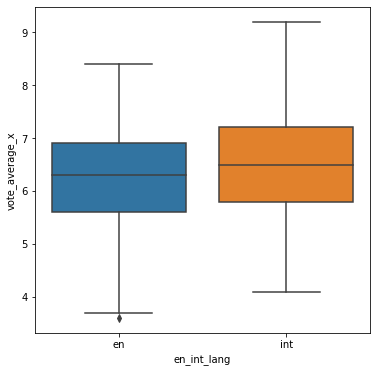

In [22]:
fig = plt.subplots(figsize = (6,6))
sns.boxplot(x='en_int_lang', y='vote_average_x', data=en_int_lang_no_outliers);

## Question 1 - Is there a difference in rating between English language movies and international language movies?

#### Null Hypothesis (H0):                Mean Rating of en = Mean Rating of int
#### Alternative Hypothesis (H1):    Mean Rating  of en ≠ Mean Rating of int

In [23]:
en_language = en_int_lang[(en_int_lang['en_int_lang'] == 'en') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']
int_language = en_int_lang[(en_int_lang['en_int_lang'] == 'int') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']

The samples are unevenly sized and the sample sizes are very large. For this reason a 2-tailed welch's t-test was performed to test the Alternative Hypothesis.

In [26]:
t = welch_ttest(en_language, int_language)
#df = welch_df(en_language, int_language)
#print(t, df)


 Welch's t-test= -3.5230 
 p-value = 0.00044948 
 Degrees of Freedom= 847.0933


In [27]:
welch_ttest(en_language, int_language)


 Welch's t-test= -3.5230 
 p-value = 0.00044948 
 Degrees of Freedom= 847.0933


**p-value < alpha (0.05): Hull Hypothesis (H0) rejected**

In [41]:
#p_value(en_language, int_language, two_sided=True)

In [29]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [30]:
c_d = Cohen_d(en_language, int_language)

In [31]:
print('effect size: ', c_d)

effect size:  -0.23192738184711365


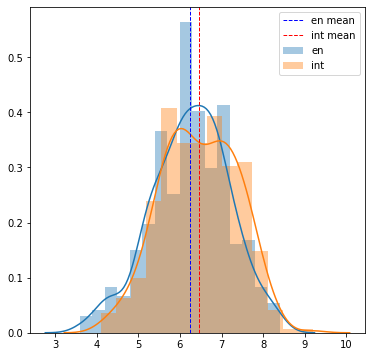

In [32]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(list(en_language), label = 'en')
sns.distplot(list(int_language), label = 'int')
plt.axvline(en_language.mean(), color='blue', linestyle='--', lw=1,label='en mean')
plt.axvline(int_language.mean(), color='red', linestyle='--', lw=1,label='int mean')
plt.legend();

In [33]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=390, alpha=.05, ratio = 556/390)

0.9391681564548459

so while we are able to reject the null hypothesis the very small effect size indicate that there is no meaningful difference in the average ratings for English language movies and non-English language movies.

### `genre_ids`

In [34]:
genre_ids.loc[genre_ids['genre_ids_outlier_flag'] == False]['genre_ids'].value_counts()

Comedy|                  126
Drama|                    90
Drama|Comedy|             57
Documentary|              27
Comedy|Romance|           26
Horror|Thriller|          25
Drama|Comedy|Romance|     17
Thriller|                 17
Drama|Romance|            17
Horror|                   16
Drama|History|            12
Name: genre_ids, dtype: int64

the top 3 genres based on the number of movies released are: Comedy, Drama and Drama|Comedy ('Dramadey')

In [35]:
genre_ids_no_outliers = genre_ids.loc[genre_ids['genre_ids_outlier_flag'] == False, ['genre_ids', 'vote_average_x']]

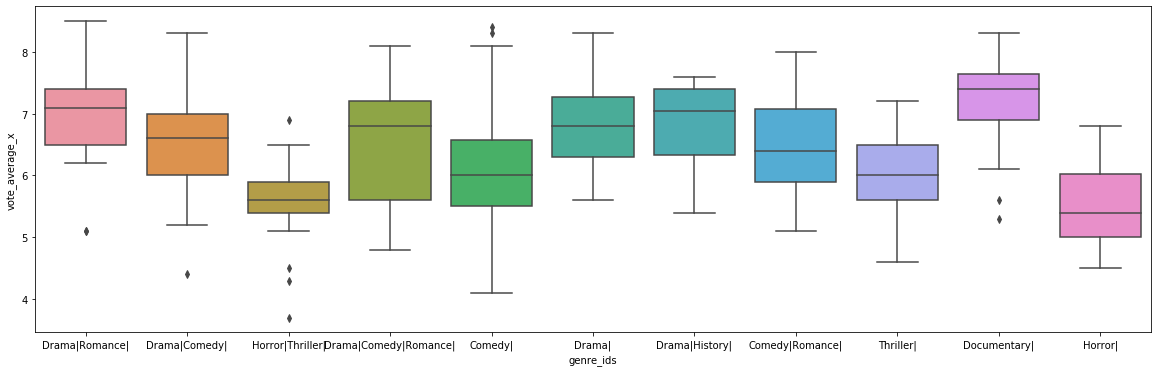

In [36]:
fig = plt.subplots(figsize = (20,6))
sns.boxplot(x='genre_ids', y='vote_average_x', data=genre_ids_no_outliers);

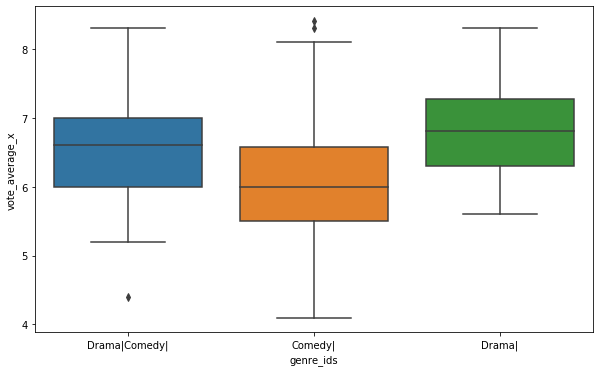

In [37]:
fig = plt.subplots(figsize = (10,6))
sns.boxplot(x='genre_ids', y='vote_average_x', data=genre_ids_no_outliers.loc[genre_ids_no_outliers['genre_ids'].isin(['Comedy|', 'Drama|', 'Drama|Comedy|'])]);

## Question 2 - Is there a difference in rating between the genres Drama, Comedy and 'Dramadey' (Drama/Comedy)?

#### Null Hypothesis (H0):                Mean Rating of Drama|Comedy = Mean Rating of Drama = Mean Rating of Comedy
#### Alternative Hypothesis (H1):    Mean Rating of Drama > Mean Rating of Comedy < Mean Rating of Drama|Comedy

In [42]:
drama_comedy_genres = ['Comedy|', 'Drama|', 'Drama|Comedy|']
genre_table = genre_ids.loc[(genre_ids['genre_ids'].isin(drama_comedy_genres)) & (genre_ids['genre_ids_outlier_flag'] == False), ['genre_ids', 'vote_average_x']]
formula = 'vote_average_x ~ C(genre_ids)'
lm = ols(formula, genre_table).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)    

                  sum_sq     df          F        PR(>F)
C(genre_ids)   33.733384    2.0  28.512357  5.830832e-12
Residual      159.720462  270.0        NaN           NaN


In [43]:
anova(formula, genre_table)

sum_sq     df    mean_sq    eta_sq  omega_sq          F  \
C(genre_ids)   33.733384    2.0  16.866692  0.174374  0.167746  28.512357   
Residual      159.720462  270.0   0.591557       NaN       NaN        NaN   

                    PR(>F)  
C(genre_ids)  5.830832e-12  
Residual               NaN

In [44]:
tab = genre_table[genre_table['genre_ids'].isin(['Comedy|','Drama|','Drama|Comedy|'])]
mc = MultiComparison(tab['vote_average_x'], tab['genre_ids'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1     group2    meandiff p-adj  lower  upper  reject
----------------------------------------------------------
Comedy|        Drama|   0.7856  0.001 0.5354 1.0357   True
Comedy| Drama|Comedy|   0.4994  0.001 0.2101 0.7888   True
 Drama| Drama|Comedy|  -0.2861 0.0734 -0.593 0.0207  False
----------------------------------------------------------


null hypothesis between Comedy and Drama rejected <br>
null hypothesis between Comedy and Drama|Comedy rejected <br>
null hypothesis between Drama and Drama|Comedy **NOT** rejected

In [45]:
comedy = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[0]]['vote_average_x'])
drama = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[1]]['vote_average_x'])
drama_comedy = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[2]]['vote_average_x'])

In [46]:
print('difference in means: ', np.array(comedy).mean() - np.array(drama).mean())
print('comedy_language sample size: ', len(comedy))
print('drama_language sample size: ', len(drama))

difference in means:  -0.7855555555555567
comedy_language sample size:  126
drama_language sample size:  90


In [48]:
#p_value(np.array(comedy), np.array(drama), two_sided=True)

In [49]:
c_d = Cohen_d(np.array(comedy), np.array(drama))

In [53]:
print('effect size: ', c_d)

effect size:  -1.023992198839946


In [55]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=120, alpha=.05, ratio = 90/126)

1.0

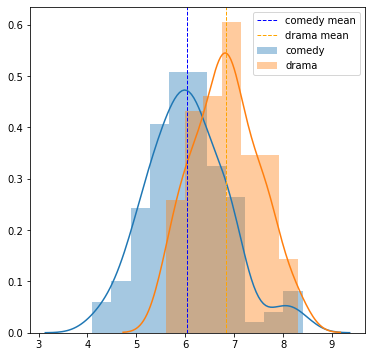

In [56]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(comedy, label = 'comedy')
sns.distplot(drama, label = 'drama')
plt.axvline(np.array(comedy).mean(), color='blue', linestyle='--', lw=1,label='comedy mean')
plt.axvline(np.array(drama).mean(), color='orange', linestyle='--', lw=1,label='drama mean')
plt.legend();

In [58]:
#p_value(np.array(comedy), np.array(drama_comedy), two_sided=True)

In [59]:
c_d = Cohen_d(np.array(comedy), np.array(drama_comedy))

In [60]:
print('effect size: ', c_d)

effect size:  -0.6187686444544191


In [61]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=120, alpha=.05, ratio = 90/120)

0.9929925119951566

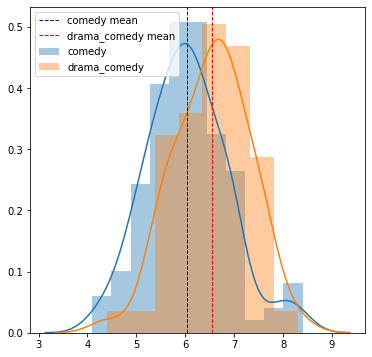

In [62]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(comedy, label = 'comedy')
sns.distplot(drama_comedy, label = 'drama_comedy')
plt.axvline(np.array(comedy).mean(), color='blue', linestyle='--', lw=1,label='comedy mean')
plt.axvline(np.array(drama_comedy).mean(), color='red', linestyle='--', lw=1,label='drama_comedy mean')
plt.legend();

Non Parametric - Kruskal - Wallis H test

In [63]:
stat, p = kruskal(comedy, drama, drama_comedy)
print('Statistics=%.3f, p=%.9f' % (stat, p))

Statistics=49.855, p=0.000000000


In [64]:
sp.posthoc_dunn([comedy, drama, drama_comedy], p_adjust = 'holm')

1             2         3
1 -1.000000e+00  1.549592e-11  0.000209
2  1.549592e-11 -1.000000e+00  0.049080
3  2.091607e-04  4.908012e-02 -1.000000

# Revenue, budget and profitability

In [65]:
df_reduced.shape

(10000, 16)

In [66]:
df_revenue = df_reduced[(df_reduced.revenue != 0) & (df_reduced.budget != 0)]

In [67]:
df_revenue = df_revenue.loc[df_revenue.budget.notnull()]

In [68]:
df_revenue = df_revenue.loc[df_revenue.revenue.notnull()]

In [69]:
df_revenue.reset_index(inplace=True)

In [70]:
df_revenue.drop(columns ='index', inplace=True)

In [71]:
df_revenue.sample(20)

popularity  vote_count_x  vote_average_x release_date  \
61       14.393        2883.0             7.6   2018-11-23   
85       11.298        1002.0             6.5   2018-09-06   
137      16.171        1736.0             7.3   2018-06-01   
81       15.969        2336.0             6.6   2018-08-29   
115       9.048         108.0             7.0   2018-03-23   
106      12.875        1192.0             6.2   2018-09-15   
157      15.035         167.0             7.2   2018-09-21   
164       0.882           6.0             6.5   2018-03-09   
154       8.751         198.0             5.9   2018-04-20   
13       29.421        3690.0             7.2   2018-11-20   
214       0.726           2.0             4.3   2018-03-14   
218       0.900           0.0             0.0   2018-02-20   
124       6.515         139.0             6.0   2018-04-06   
100       9.308         210.0             6.7   2018-03-30   
227       0.600           0.0             0.0   2018-05-03   
220       0.600           0.0             0.0   2018-08-12   
252       0.627           0.0             0.0   2018-10-26   
152       1.151           2.0             4.5   2018-10-18   
241       0.682           0.0             0.0   2018-12-18   
97       13.113         909.0             6.6   2018-12-07   

    original_language_x                                genre_ids  \
61                   en                    Drama|Comedy|History|   
85                   en                         Action|Thriller|   
137                  en  Horror|Action|Thriller|Science Fiction|   
81                   en                            Comedy|Crime|   
115                  en                                 History|   
106                  en                          Fantasy|Family|   
157                  en                           Drama|Romance|   
164                  hi                    Drama|Thriller|Crime|   
154                  en                         Horror|Thriller|   
13                   en       Adventure|Animation|Comedy|Family|   
214                  fa                  Drama|Thriller|Romance|   
218                  fa                                   Drama|   
124                  en                  Drama|History|Thriller|   
100                  en                                Thriller|   
227                  fa                                  Comedy|   
220                  en                                      na|   
252                  en                                 Romance|   
152                  en                          Romance|Family|   
241                  en                            Drama|Family|   
97                   en                           Drama|History|   

         belongs_to_collection       budget      production_companies  \
61                          na   15000000.0    Waypoint Entertainment   
85                          na   25000000.0         STX Entertainment   
137                         na    5000000.0         Goalpost Pictures   
81                          na   20000000.0      Feigco Entertainment   
115                         na    5000000.0            Outside Da Box   
106                         na   42000000.0      Amblin Entertainment   
157                         na   10000000.0  FilmNation Entertainment   
164      Hate Story Collection    2900000.0                  T-Series   
154                         na    4000000.0  Hidden Empire Film Group   
13   Wreck-It Ralph Collection  175000000.0      Walt Disney Pictures   
214                         na      10000.0               Simaye Mehr   
218                         na      10000.0               Simaye Mehr   
124                         na   34000000.0        Apex Entertainment   
100                         na   20000000.0       Tyler Perry Studios   
227                         na       1000.0      Iranian Independents   
220                         na        127.0                        na   
252                         na  

## Question 3 - Is there a difference in rating between profitable movies and unprofitable movies?

## Hypothesis:

### H0: no significant difference in budget between profitable and unprofitable movies
### Ha: there is a significant difference in budget between profitable and unprofitable movies

In [72]:
df_revenue['profitable'] = df_revenue.revenue - df_revenue.budget

df_revenue.loc[df_revenue.profitable > 0, 'profitable'] = 1
df_revenue.loc[df_revenue.profitable <= 0, 'profitable'] = 0

In [73]:
df_revenue.head()

popularity  vote_count_x  vote_average_x release_date original_language_x  \
0      82.250       16683.0             8.3   2018-04-25                  en   
1      38.895       14192.0             7.4   2018-02-13                  en   
2      31.957        6878.0             6.5   2018-06-06                  en   
3      30.431        7607.0             7.5   2018-06-14                  en   
4      31.991        7849.0             6.8   2018-12-07                  en   

                                   genre_ids       belongs_to_collection  \
0          Adventure|Action|Science Fiction|     The Avengers Collection   
1  Adventure|Fantasy|Action|Science Fiction|    Black Panther Collection   
2          Adventure|Action|Science Fiction|    Jurassic Park Collection   
3         Adventure|Animation|Action|Family|  The Incredibles Collection   
4                  Adventure|Fantasy|Action|          Aquaman Collection   

        budget  production_companies production_countries       revenue  \
0  300000000.0        Marvel Studios                   US  2.046240e+09   
1  200000000.0        Marvel Studios                   US  1.346739e+09   
2  170000000.0  Amblin Entertainment                   US  1.303460e+09   
3  200000000.0  Walt Disney Pictures                   US  1.241891e+09   
4  160000000.0             DC Comics                   AU  1.143689e+09   

   day_of_week  month  quarter en_int_lang  collection  profitable  
0            2      4        2          en  Collection         1.0  
1            1      2        1          en  Collection         1.0  
2            2      6        2          en  Collection         1.0  
3            3      6        2          en  Collection         1.0  
4            4     12        4          en  Collection         1.0

In [75]:
df_revenue.sample(20)

popularity  vote_count_x  vote_average_x release_date  \
73       15.495        1804.0             7.1   2018-12-25   
85       11.298        1002.0             6.5   2018-09-06   
105      12.272         761.0             5.4   2018-03-07   
185       1.278           8.0             6.9   2018-02-16   
166       9.005         436.0             7.0   2018-06-01   
130      10.165         837.0             6.2   2018-02-21   
12       33.307          72.0             6.6   2018-02-16   
37       10.871        1313.0             6.2   2018-09-13   
44       19.113        3278.0             6.9   2018-02-22   
147       8.658         532.0             7.3   2018-10-19   
167      11.031         586.0             7.0   2018-05-18   
35       14.604        1532.0             6.1   2018-01-03   
97       13.113         909.0             6.6   2018-12-07   
175       1.438          11.0             7.0   2018-10-18   
45        3.817          51.0             6.1   2018-11-29   
116       9.076         287.0             5.5   2018-01-12   
65        8.049         407.0             6.1   2018-05-18   
171       9.603         442.0             7.0   2018-07-18   
88       17.427        1413.0             6.6   2018-11-01   
227       0.600           0.0             0.0   2018-05-03   

    original_language_x                    genre_ids  \
73                   en        Drama|Comedy|History|   
85                   en             Action|Thriller|   
105                  en             Horror|Thriller|   
185                  ml                       Drama|   
166                  en     Drama|Crime|Documentary|   
130                  en             Horror|Thriller|   
12                   zh   Drama|Action|Thriller|War|   
37                   en                      Comedy|   
44                   en        Comedy|Crime|Mystery|   
147                  en                Drama|Comedy|   
167                  en                       Drama|   
35                   en     Horror|Thriller|Mystery|   
97                   en               Drama|History|   
175                  ru      Drama|Thriller|Romance|   
45                   ta      Action|Science Fiction|   
116                  en       Action|Thriller|Crime|   
65                   en        Drama|Comedy|Romance|   
171                  en                       Drama|   
88                   en  Horror|Science Fiction|War|   
227                  fa                      Comedy|   

         belongs_to_collection      budget     production_companies  \
73                          na  60000000.0     Plan B Entertainment   
85                          na  25000000.0        STX Entertainment   
105   The Strangers Collection  12500000.0          Aviron Pictures   
185                         na   2340000.0  Goodwill Entertainments   
166                         na   3000000.0        Film4 Productions   
130                         na   1500000.0      Regency Enterprises   
12                          na  70000000.0          Bona Film Group   
37   Johnny English Collection  25000000.0       Universal Pictures   
44                          na  37000000.0          New Line Cinema   
147                         na    258157.0   Waypoint Entertainment   
167                         na   3500000.0           Arclight Films   
35        Insidious Collection  10000000.0            Stage 6 Films   
97                          na  25000000.0           Focus Features   
175                         na   1504710.0                Синетрейн   
45            Robot Collection  77000000.0         Lyca Productions   
116                         na  14000000.0              Screen Gems   
65                          na  10000000.0            June Pictures   
171                         na    900000.0          Beachside Films   
88                          na  38000000.0                Bad Robot   
227                         na      1000.0     Iranian Independents   

    production_countries      rev

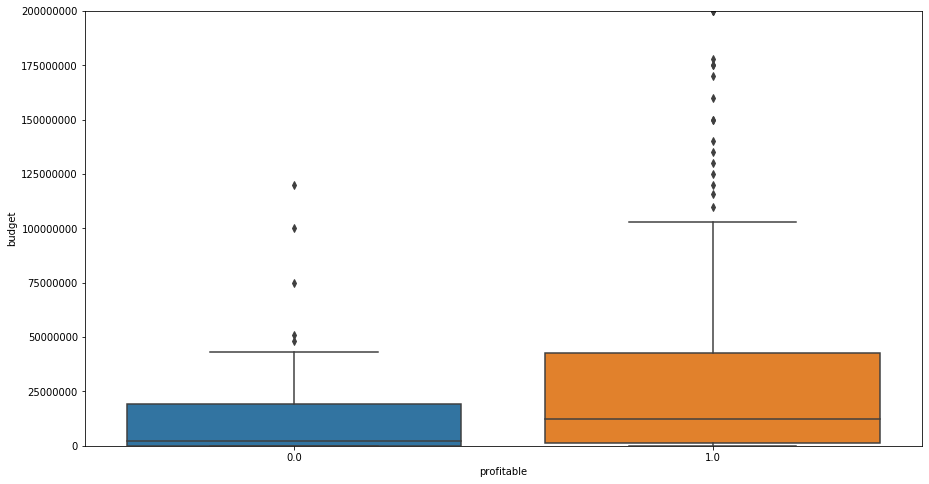

In [76]:
plt.figure(figsize=(15,8))
plt.ylim(top=200000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="profitable", y="budget", data=df_revenue)
plt.show()

In [77]:
df_profitable = df_revenue[df_revenue['profitable'] ==1]
df_not_profitable = df_revenue[df_revenue['profitable'] ==0]

df_revenue.groupby('profitable')['budget'].describe()

count          mean           std  min        25%         50%  \
profitable                                                                  
0.0          86.0  1.301122e+07  2.208137e+07  5.0     3250.0   2170000.0   
1.0         174.0  3.581609e+07  5.420961e+07  1.0  1501177.5  12250000.0   

                    75%          max  
profitable                            
0.0         19000000.00  120000000.0  
1.0         42802059.75  300000000.0

In [78]:
# Levene's test for homogeneity of variance  is significant 
# so should conduct Welch's T-Test instead of students T-Test
stats.levene(df_profitable['budget'], df_not_profitable['budget'])

LeveneResult(statistic=13.066944691228477, pvalue=0.0003613344765608587)

In [79]:
# residuals not normally distributed so should use nonparametric tests

print(stats.shapiro(df_profitable['revenue']))
print(stats.shapiro(df_not_profitable['revenue']))

(0.5553759336471558, 6.572560254773633e-21)
(0.5672418475151062, 1.578704919883659e-14)


In [80]:

#mann whitney test at alpha = 0.05

mann_whitney_u(df_profitable['budget'], df_not_profitable['budget'])

Statistics=4902.500, p=0.000
Different distribution (reject H0)


#### p < 0.05 so can reject H0:
   therefore there is a significant difference in budget between profitable and unprofitable films

## Question 4 - Is there a difference in rating between movies based on the day/period of release?

In [99]:
df_revenue.loc[df_revenue.day_of_week == 0, 'day_of_week'] = 'Mon'
df_revenue.loc[df_revenue.day_of_week == 1, 'day_of_week'] = 'Tue'
df_revenue.loc[df_revenue.day_of_week == 2, 'day_of_week'] = 'Wed'
df_revenue.loc[df_revenue.day_of_week == 3, 'day_of_week'] = 'Thu'
df_revenue.loc[df_revenue.day_of_week == 4, 'day_of_week'] = 'Fri'
df_revenue.loc[df_revenue.day_of_week == 5, 'day_of_week'] = 'Sat'
df_revenue.loc[df_revenue.day_of_week == 6, 'day_of_week'] = 'Sun'

# data1 = df_revenue['revenue'][df_revenue['day_of_week'] == 0]
# data2 = df_revenue['revenue'][df_revenue['day_of_week'] == 1]
# data3 = df_revenue['revenue'][df_revenue['day_of_week'] == 2]
# data4 = df_revenue['revenue'][df_revenue['day_of_week'] == 3]
# data5 = df_revenue['revenue'][df_revenue['day_of_week'] == 4]
# data6 = df_revenue['revenue'][df_revenue['day_of_week'] == 5]
# data7 = df_revenue['revenue'][df_revenue['day_of_week'] == 6]

## Hypothesis :

### H0: no significant difference in revenue between films released at different times
### Ha: there is a significant difference in revenue between films released at different times

This will be broken down into three hypotheses: month, quarter and day of the week

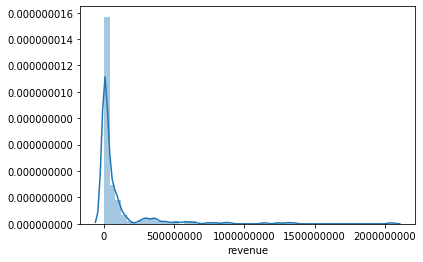

In [81]:
plt.ticklabel_format(style='plain')
sns.distplot(df_revenue['revenue'])

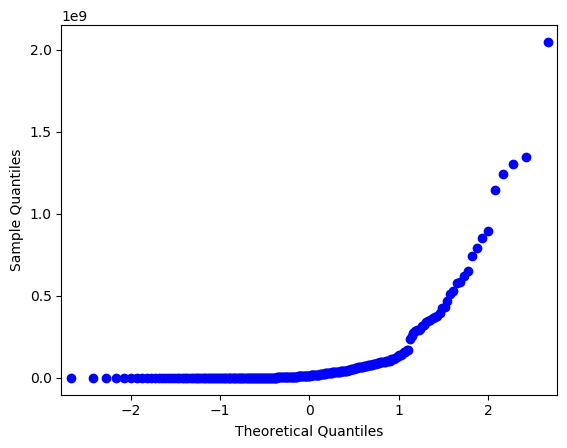

In [181]:
# qq plot shows not normally distributed

sm.qqplot(df_revenue['revenue'])
pylab.show()

In [83]:
stats.shapiro(df_revenue['revenue'])

(0.4618762135505676, 2.69166447542904e-27)

In [84]:
data1 = df_revenue['revenue'][df_revenue['quarter'] == 1]
data2 = df_revenue['revenue'][df_revenue['quarter'] == 2]
data3 = df_revenue['revenue'][df_revenue['quarter'] == 3]
data4 = df_revenue['revenue'][df_revenue['quarter'] == 4]

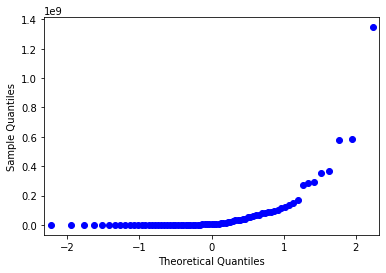

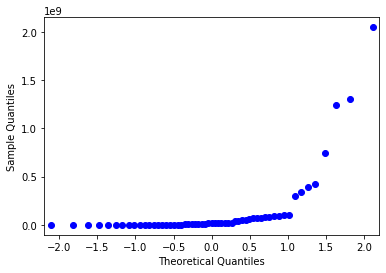

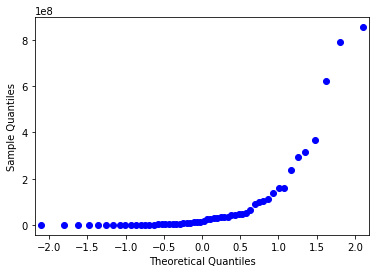

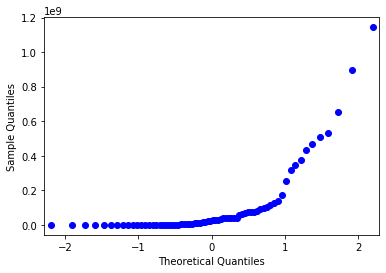

In [85]:
sm.qqplot(data1)
sm.qqplot(data2)
sm.qqplot(data3)
sm.qqplot(data4)
pylab.show()

In [86]:
print(stats.shapiro(data1))
print(stats.shapiro(data2))
print(stats.shapiro(data3))
print(stats.shapiro(data4))

(0.4457833170890808, 1.5465218607010845e-15)
(0.42829442024230957, 1.4706962590035205e-13)
(0.535047173500061, 4.695506570367991e-12)
(0.5714941024780273, 5.543234057533986e-13)


In [87]:
kw_test(data1,data2,data3,data4)

Statistics=3.710, p=0.294
Same distributions (fail to reject H0)


In [102]:
data1 = df_revenue['revenue'][df_revenue['month'] == 1]
data2 = df_revenue['revenue'][df_revenue['month'] == 2]
data3 = df_revenue['revenue'][df_revenue['month'] == 3]
data4 = df_revenue['revenue'][df_revenue['month'] == 4]
data5 = df_revenue['revenue'][df_revenue['month'] == 5]
data6 = df_revenue['revenue'][df_revenue['month'] == 6]
data7 = df_revenue['revenue'][df_revenue['month'] == 7]
data8 = df_revenue['revenue'][df_revenue['month'] == 8]
data9 = df_revenue['revenue'][df_revenue['month'] == 9]
data10 = df_revenue['revenue'][df_revenue['month'] == 10]
data11 = df_revenue['revenue'][df_revenue['month'] == 11]
data12 = df_revenue['revenue'][df_revenue['month'] == 12]

In [194]:
i

'data12'

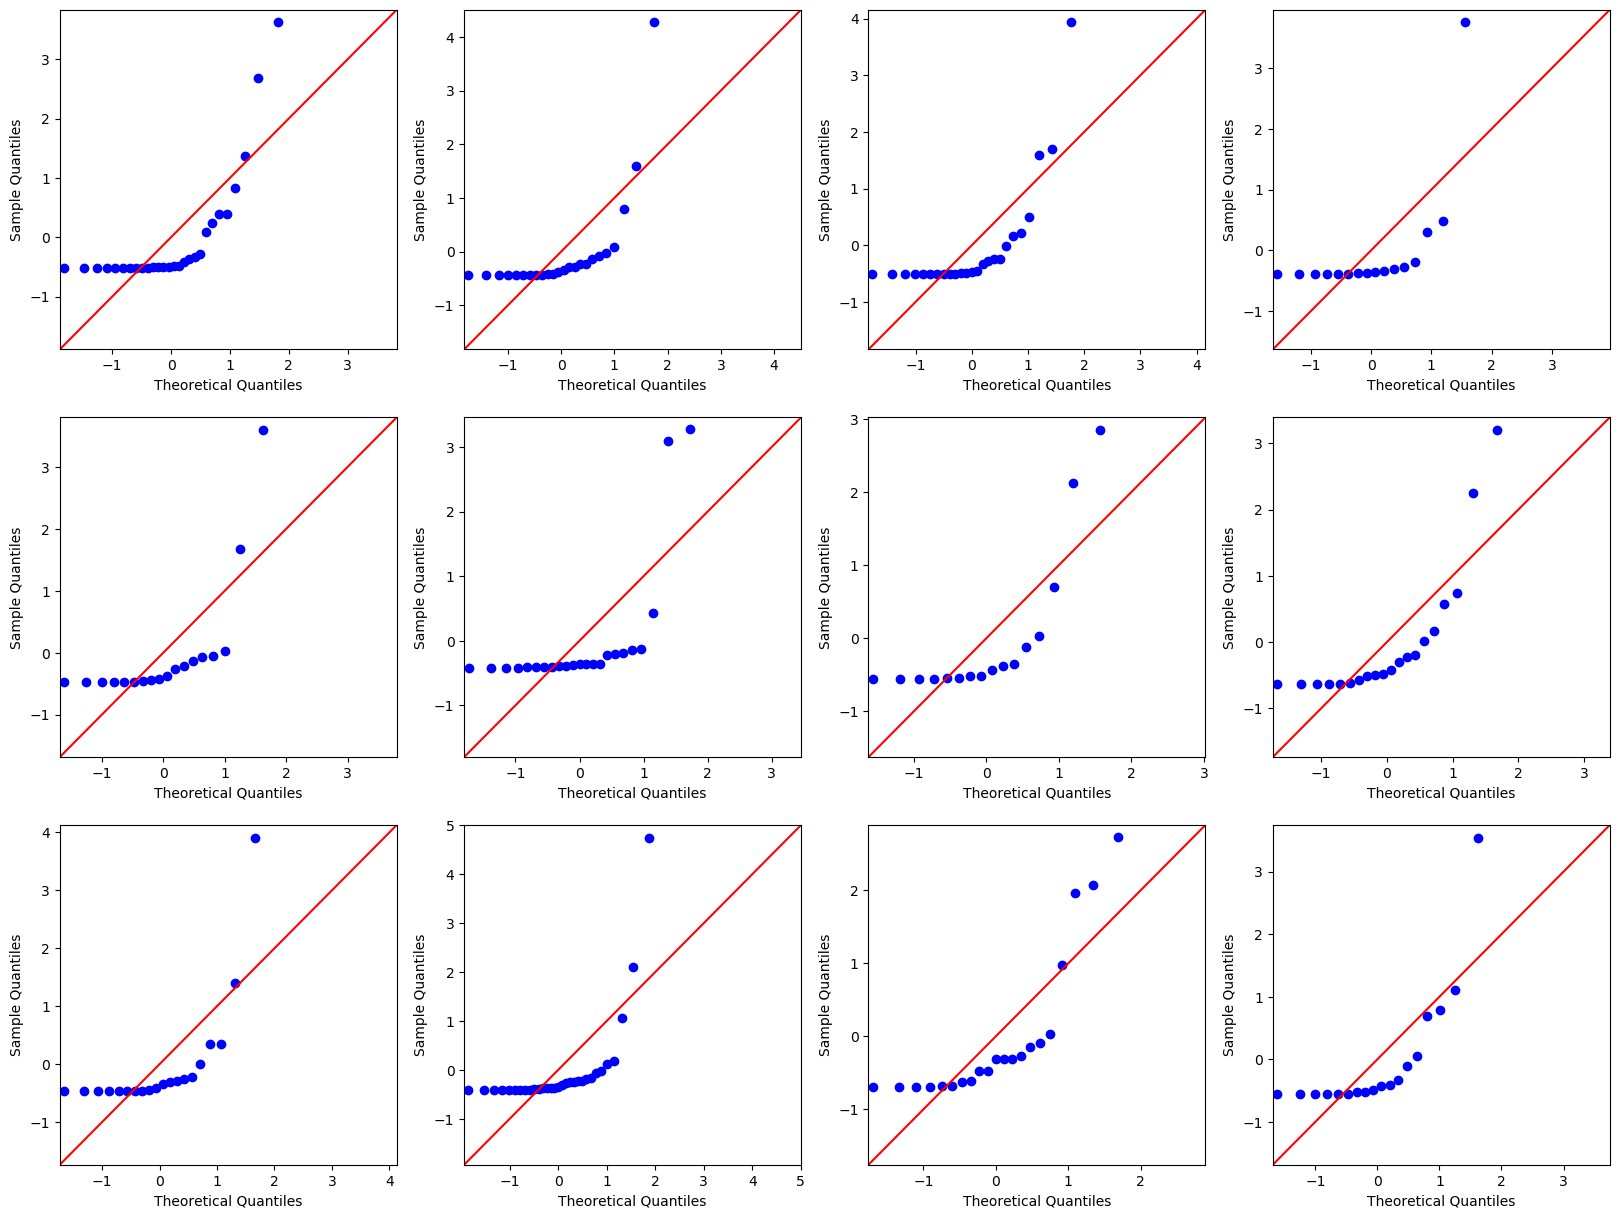

In [214]:
fig2, axes2 = plt.subplots(3, 4, figsize = (20, 15))
axes2.shape

for n in range(1,13):
    
    i = 'data'+str(n)
    
    row = (n-1)//4
    col = (n-1)%4
    exec(f'probplot = sm.ProbPlot({i}, fit=True)')
    ax = axes2[row][col]
    probplot.qqplot(line='45', ax = axes2[row][col])


In [104]:
print(stats.shapiro(data1))
print(stats.shapiro(data2))
print(stats.shapiro(data3))
print(stats.shapiro(data4))
print(stats.shapiro(data5))
print(stats.shapiro(data6))
print(stats.shapiro(data7))
print(stats.shapiro(data8))
print(stats.shapiro(data9))
print(stats.shapiro(data10))
print(stats.shapiro(data11))
print(stats.shapiro(data12))

(0.5872861742973328, 1.0291143581753204e-07)
(0.4744981527328491, 3.2174181541222424e-08)
(0.5671519041061401, 1.8436843163271988e-07)
(0.42540156841278076, 5.426601887847937e-07)
(0.5154024362564087, 1.0935867749140016e-06)
(0.44105851650238037, 2.455123926381475e-08)
(0.6127083897590637, 2.138791751349345e-05)
(0.6581008434295654, 1.2543159755296074e-05)
(0.5129270553588867, 4.169946521415113e-07)
(0.4349515438079834, 7.960379022620145e-10)
(0.6895983219146729, 2.048513852059841e-05)
(0.6117869019508362, 8.87636542756809e-06)


None of the qqplots, nore the Shapiro tests, by month of year, indicate normality. <br>
Therefore, we will use non-parametric tests to test for differences between the mean revenue by month:

In [105]:
kw_test(data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12)

Statistics=9.011, p=0.621
Same distributions (fail to reject H0)


In [106]:
data_m = df_revenue['revenue'][df_revenue['day_of_week'] == 'Mon']
data_t = df_revenue['revenue'][df_revenue['day_of_week'] == 'Tue']
data_w = df_revenue['revenue'][df_revenue['day_of_week'] == 'Wed']
data_th = df_revenue['revenue'][df_revenue['day_of_week'] == 'Thu']
data_f = df_revenue['revenue'][df_revenue['day_of_week'] == 'Fri']
data_s = df_revenue['revenue'][df_revenue['day_of_week'] == 'Sat']
data_su = df_revenue['revenue'][df_revenue['day_of_week'] == 'Sun']

In [107]:
kw_test(data_m,data_t,data_w,data_th,data_f,data_s,data_su)

Statistics=32.482, p=0.000
Different distributions (reject H0)


In [109]:
data_list = [data_m,data_t,data_w,data_th,data_f,data_s,data_su]

dunn_test(data_list)

1         2         3         4         5         6         7
1 -1.000000  1.000000  0.002807  0.012901  0.252334  1.000000  1.000000
2  1.000000 -1.000000  0.130513  0.382736  1.000000  1.000000  0.889961
3  0.002807  0.130513 -1.000000  1.000000  0.110578  0.145988  0.007297
4  0.012901  0.382736  1.000000 -1.000000  0.477059  0.349721  0.024061
5  0.252334  1.000000  0.110578  0.477059 -1.000000  1.000000  0.252334
6  1.000000  1.000000  0.145988  0.349721  1.000000 -1.000000  1.000000
7  1.000000  0.889961  0.007297  0.024061  0.252334  1.000000 -1.000000

In [114]:
x=df_revenue['revenue'][df_revenue['day_of_week'] == 'Wed']
y=df_revenue['revenue'][df_revenue['day_of_week'] != 'Wed']

In [115]:
mann_whitney_u(x,y)

Statistics=4057.500, p=0.001
Different distribution (reject H0)


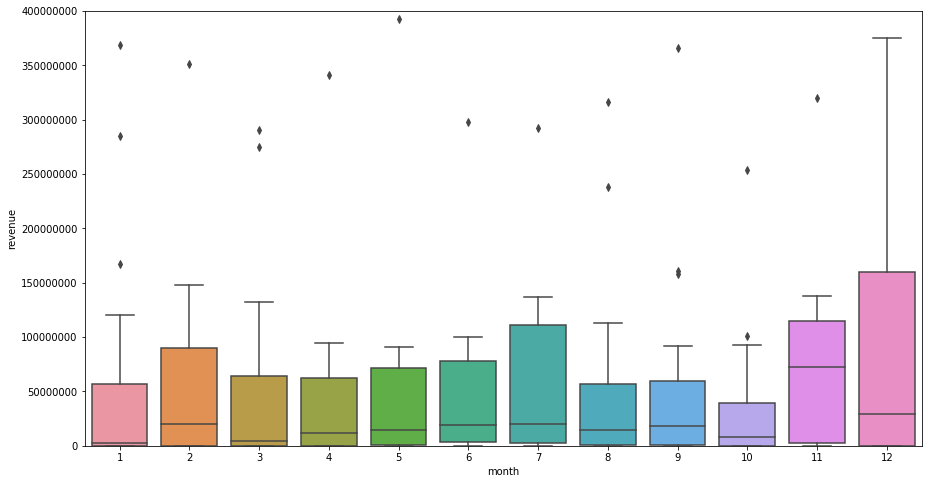

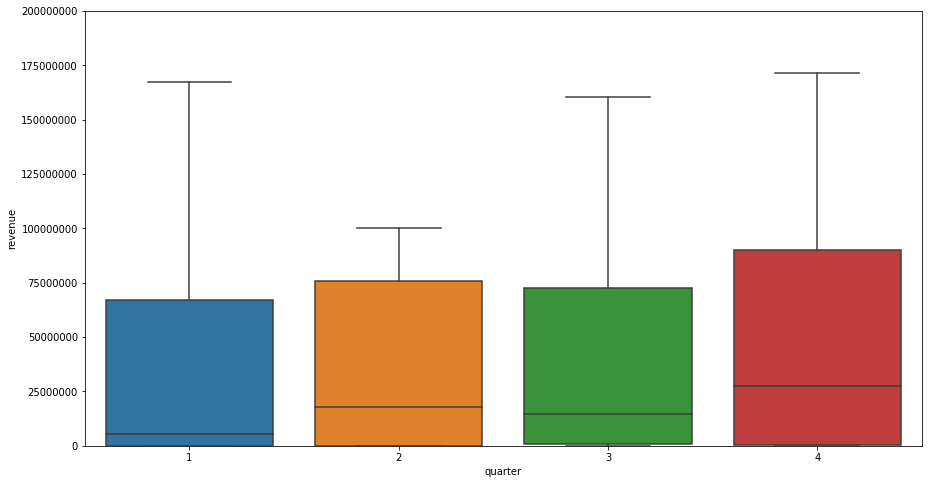

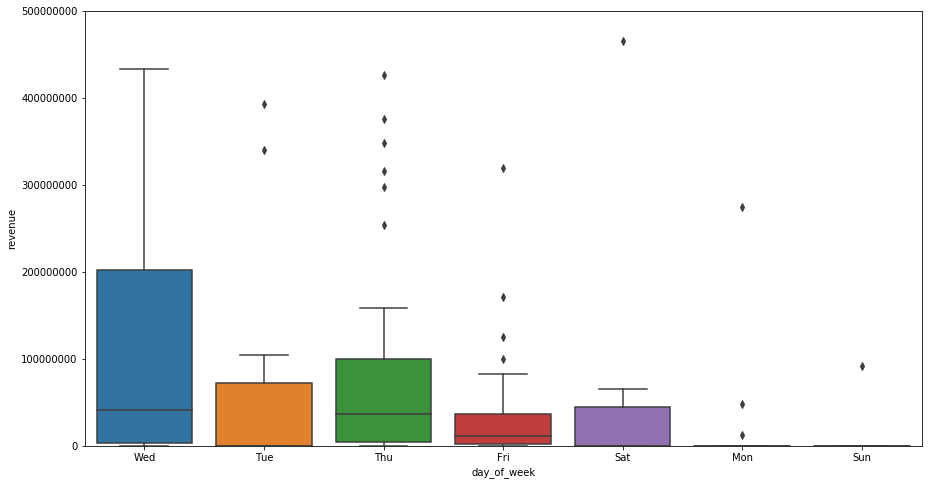

In [116]:
plt.figure(figsize=(15,8))
plt.ylim(top=400000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="month", y="revenue", data=df_revenue)

plt.figure(figsize=(15,8))
plt.ylim(top=200000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="quarter", y="revenue", data=df_revenue)

plt.figure(figsize=(15,8))
plt.ylim(top=500000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="day_of_week", y="revenue", data=df_revenue)

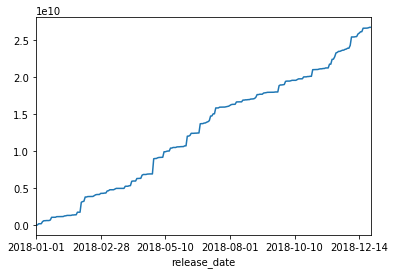

In [98]:
ser = df_revenue.set_index('release_date')
ser['revenue'].sort_index().cumsum().plot()

In [122]:
ser_df = ser['revenue'].sort_index().cumsum().reset_index()

release_date       revenue
0     2018-01-01  5.000000e+00
1     2018-01-01  2.390050e+05
2     2018-01-03  1.674231e+08
3     2018-01-05  1.709242e+08
4     2018-01-09  1.724242e+08
..           ...           ...
255   2018-12-18  2.658576e+10
256   2018-12-21  2.659854e+10
257   2018-12-25  2.663900e+10
258   2018-12-25  2.670527e+10
259   2018-12-30  2.670533e+10

[260 rows x 2 columns]

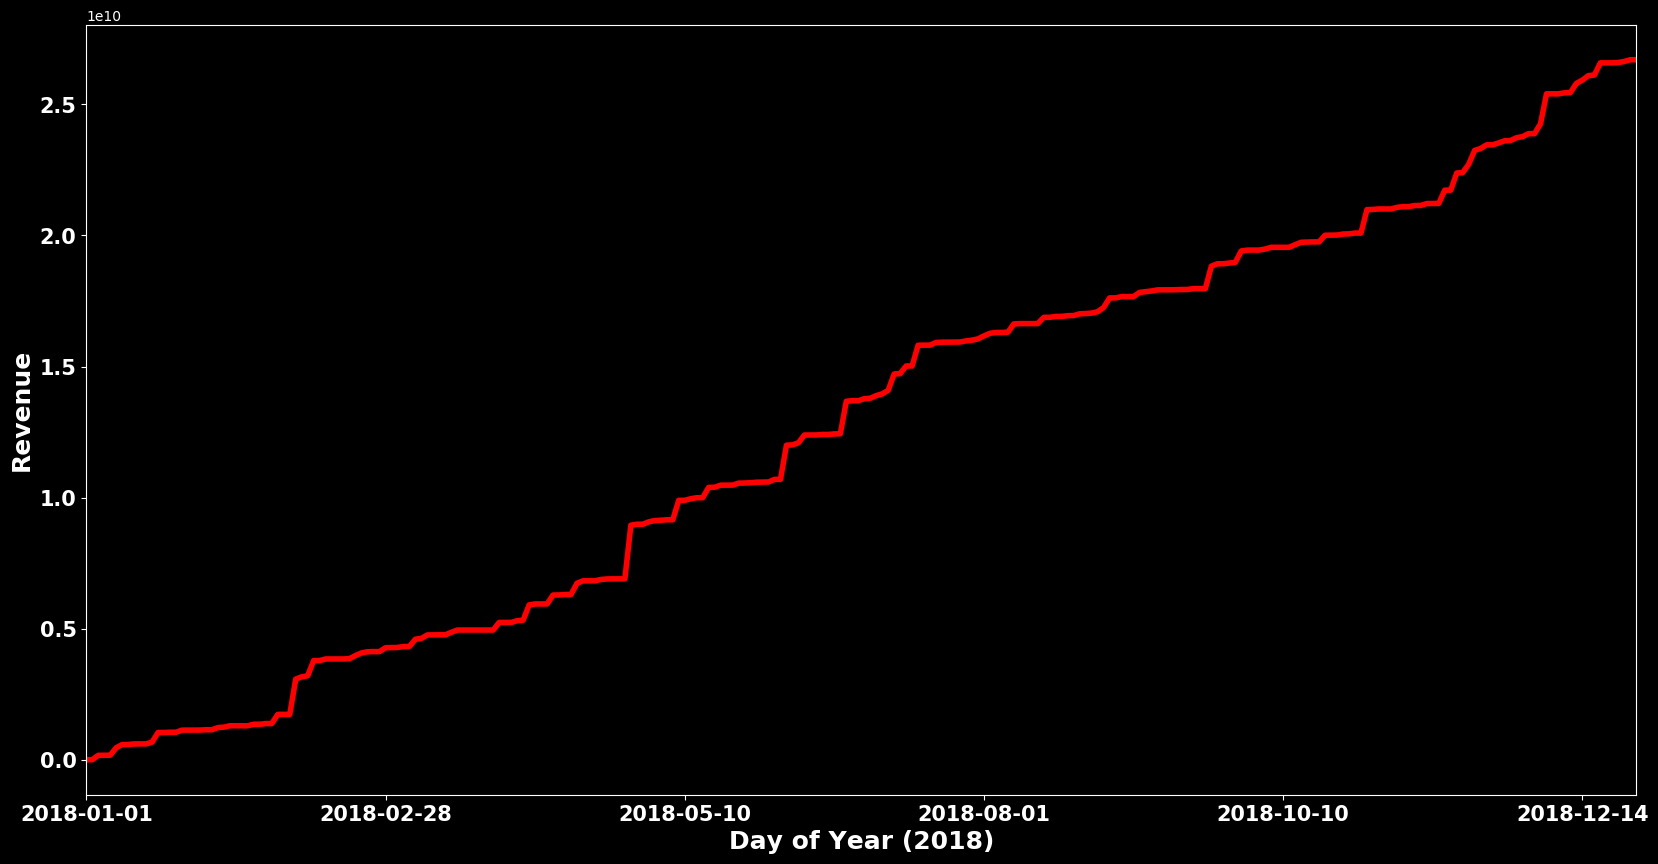

In [176]:
plt.style.use("dark_background")

plt.figure(figsize = (20, 10))
g = ser['revenue'].sort_index().cumsum().plot(linewidth = 4, color = 'red')
plt.xlabel('Day of Year (2018)', fontsize=18, weight = 'bold')
plt.ylabel('Revenue', fontsize=18, weight = 'bold')
plt.xticks(fontsize = 15, weight = 'bold')
plt.yticks(fontsize = 15, weight = 'bold');